# Radiation Source Localization
Author(s): Paul Miles, Jason Hite | August 15, 2018

__Return to [Index](https://nbviewer.jupyter.org/github/prmiles/notebooks/blob/master/pymcmcstat/index.ipynb)__

This example demonstrates how MCMC methods can be used to locate unknown sources of gamma radiation in an urban environment.  For this demonstration we consider a simulated 250m x 178m block of downtown Washington D.C.

We utilize a highly simplified radiation transport model which ignores scattering.  The model consists of the following components.  There are $N_d$ gamma detectors located at positions $\mathbf{r}_i, i = 1, ..., N_d$.  A ray tracing algorithm is implemented for a source located at $\mathbf{r}_0 = (x_0, y_0)$ with intensity $I_0$.  Buildings affect the readings of the gamma detectors, so we have modeled their impact using a exponential decay function that depends on the building dimensions and average cross-section. For the $i^{th}$ detector, we let $N_i$ denote the number of buildings between $\mathbf{r}_0$ and $\mathbf{r}_i$.  For $n_i = 1,...,N_i$, we let $s_{n_i}$ and $\sigma_{n_i}$ denote the length of the building segment and the average cross-section of the $n_i^{th}$ building, respectively.  The surface area, efficiency, and measurement duration for the $i^{th}$ detector are denoted by $A_i, \varepsilon_i,$ and $\Delta t_i$, respectively.  Finally, $B_i$ represents the expected background count rate at position $\mathbf{r}_i$. 
$$
\Gamma_i = \frac{\Delta t_i\varepsilon_iA_iI_0}{4\pi|\mathbf{r}_i - \mathbf{r}_0|^2}\exp\Big(-\sum_{n_i=1}^{N_i}\sigma_{n_i}s_{n_i}\Big) + E[B_i\Delta t_i]
$$

This model is implemented in the open source Python package [gefry3](https://github.com/jasonmhite/gefry3).  For additional reading on this area of research, please refer to the following articles:

- Hite, J., & Mattingly, J. (2018). Bayesian Metropolis Methods for Source Localization in an Urban Environment. Radiation Physics and Chemistry. [https://doi.org/10.1016/j.radphyschem.2018.06.024](https://doi.org/10.1016/j.radphyschem.2018.06.024)
- Ştefănescu, R., Schmidt, K., Hite, J., Smith, R. C., & Mattingly, J. (2017). Hybrid optimization and Bayesian inference techniques for a non‐smooth radiation detection problem. International Journal for Numerical Methods in Engineering, 111(10), 955-982. [https://doi.org/10.1002/nme.5491](https://doi.org/10.1002/nme.5491)
- Hite, J. M., Mattingly, J. K., Schmidt, K. L., Ştefănescu, R., & Smith, R. (2016, September). Bayesian metropolis methods applied to sensor networks for radiation source localization. In Multisensor Fusion and Integration for Intelligent Systems (MFI), 2016 IEEE International Conference on (pp. 389-393). IEEE. [https://doi.org/10.1109/MFI.2016.7849519](https://doi.org/10.1109/MFI.2016.7849519)

__Acknowledgment:__
Funding for this research provided by the [Consortium for Nonproliferation Enabling Capabilities (CNEC)](https://cnec.ncsu.edu/).

In [1]:
# import required packages
import gefry3
import numpy as np
from pymcmcstat.MCMC import MCMC
import mcmcplot.mcmatplot as mcmpl
import mcmcplot.mcseaborn as mcsbn
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib.pyplot as plt

# Define Radiation Model, Problem Domain, and Background Radiation

In [8]:
# Setup Radiation Model - Downtown Urban Environment Simulation
P = gefry3.read_input_problem('g3_deck.yml', problem_type = 'Simple_Problem')
observations = np.loadtxt('g3_deck_observations.dat')

# parametric upper and lower bounds. 
XMIN, YMIN, XMAX, YMAX = P.domain.all.bounds
lb = np.array([XMIN, YMIN, 10**8.])
ub = np.array([XMAX, YMAX, 10**10.]) # grid is [x (m), y (m), I (Bq)]

# define background radiation
background = 300.

# Define Sum-of-Squares Error Function.

In [9]:
# Radiation Sum of Squares Function
def radiation_ssfun(theta, data):
    # unpack theta
    x = theta[0]
    y = theta[1]
    I = theta[2]
    background = theta[3]
    # extract radiation model
    radiation_model = data.user_defined_object[0]
    # evaluate radiation model
    output = np.rint(radiation_model((x,y),I)) + background
    # compute residual
    res = data.ydata[0] - output
    # compute sum-of-squares error
    ss = np.dot(res.reshape(1, res.size), res.reshape(res.size, 1))
    return ss

# Initialize MCMC Object and Setup Simulation
Note, we pass the radiation model into our residual function via the data structure.  Also note, the background is included as a parameter, but it is not sampled during the simulation.

In [10]:
# Initialize MCMC object
mcstat = MCMC()
# setup data structure for dram
mcstat.data.add_data_set(x = np.zeros(observations.shape), y = observations, user_defined_object = P)
# initialize parameter array
mcstat.parameters.add_model_parameter(name = '$x_0$', theta0 = 140., minimum = lb[0], maximum = ub[0])
mcstat.parameters.add_model_parameter(name = '$y_0$', theta0 = 85., minimum = lb[1], maximum = ub[1])
mcstat.parameters.add_model_parameter(name = '$I_0$', theta0 = 3.0e9, minimum = lb[2], maximum = ub[2])
mcstat.parameters.add_model_parameter(name = '$BG$', theta0 = background, sample = 0)
# update simulation options
mcstat.simulation_options.define_simulation_options(nsimu = int(1.0e4), updatesigma = 1, method = 'dram', adaptint = 100)
# update model settings
mcstat.model_settings.define_model_settings(sos_function = radiation_ssfun)

# Run Simulation

In [11]:
# Run mcmcrun
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
     $x_0$:    140.00 [ 0.00e+00,    246.62] N( 0.00e+00,      inf)
     $y_0$:     85.00 [ 0.00e+00,    176.33] N( 0.00e+00,      inf)
     $I_0$:  3.00e+09 [ 1.00e+08,  1.00e+10] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 10000 of 10000 complete in 756.8 sec

# Process Results and Display Statistics


---------------------
name      :       mean        std     MC_err        tau     geweke
$x_0$     :   156.6010     1.1662     0.0627    10.0176     0.9991
$y_0$     :    98.3513     1.2371     0.0510     9.7239     0.9990
$I_0$     :  4.504e+09  3.722e+08 14942686.3867     9.8678     0.9840
---------------------
Acceptance rate:  72.09%


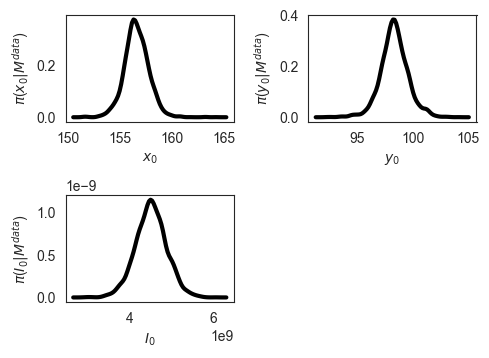

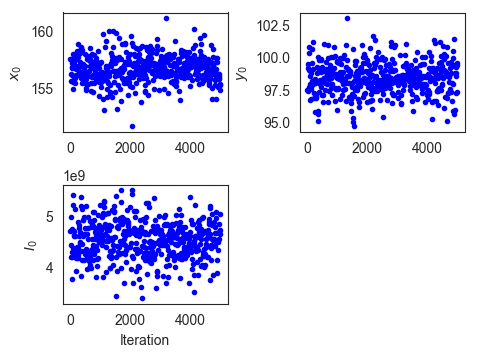

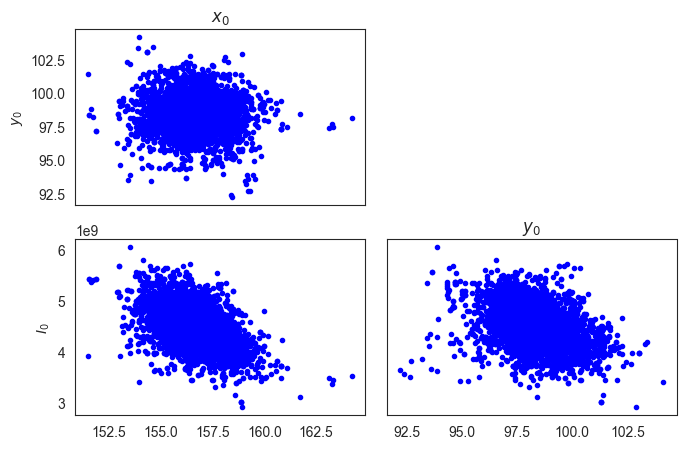

In [12]:
results = mcstat.simulation_results.results
# specify burnin period
burnin = int(results['nsimu']/2)
# display chain statistics
chain = results['chain']
s2chain = results['s2chain']
sschain = results['sschain']
names = results['names']
mcstat.chainstats(chain[burnin:,:], results)
print('Acceptance rate: {:6.4}%'.format(100*(1 - results['total_rejected'])))
# generate mcmc plots
sns.set_style('white')
mcmpl.plot_density_panel(chain[burnin:,:], names); # last argument turns hist on/off
mcmpl.plot_chain_panel(chain[burnin:,:], names);
mcmpl.plot_pairwise_correlation_panel(chain[burnin:,:], names);

# Generate Plot of Urban Environment With Source Location Distributions
First we define a function to allow us to add axes within a figure.

In [13]:
def add_subplot_axes(ax,rect,**kwargs):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],**kwargs)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

We set the context of our displays to "talk" which will improve their visibility for presentation.  To begin, we will plot the joint distribution relative to the true source location.

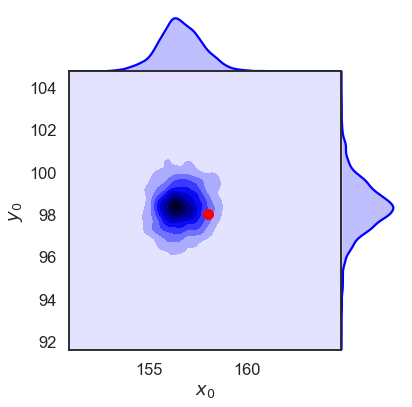

In [14]:
sns.set_context('talk')
settings = dict(jointplot = dict(kind = 'kde', color = 'b'), marginal_kws = dict(alpha = 1))
fig0, us0 = mcsbn.plot_joint_distributions(chain[burnin:,0:2], names, sns_style='white', settings = settings);
# add source
fig0[0].ax_joint.plot(P.source.R[0], P.source.R[1], 'or', linewidth = 3, markerfacecolor = 'r', markersize = 10, label = 'True Source');

Next, we plot the joint distributions relative to our entire simulated urban environment.  We have added an insert to highlight the relative positioning of the posterior distributions and the true source location.

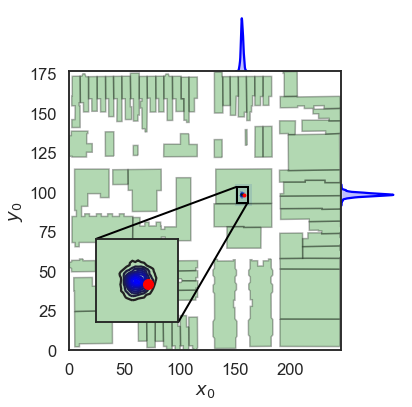

In [17]:
settings = dict(jointplot = dict(kind = 'kde', color = 'b'), marginal_kws = dict(alpha = 1))
fig, us = mcsbn.plot_joint_distributions(chain[burnin:,0:2], names, sns_style='white', settings = settings);
f = fig[0]
f.ax_marg_x.set_xlim([XMIN, XMAX])
f.ax_marg_y.set_ylim([YMIN, YMAX])
ax = f.ax_joint
# add source
ax.plot(P.source.R[0], P.source.R[1], 'or', linewidth = 3, markerfacecolor = 'r', markersize = 3)
# add buildings to plot
for building in P.domain.solids:
    patch = PolygonPatch(building.geom, alpha=0.3, facecolor = 'g', edgecolor = 'k', )
    ax.add_patch(patch)
# Create insert
rect = [0.1,0.1,0.3,0.3]
ax1 = add_subplot_axes(ax,rect,facecolor = 'w')
sns.kdeplot(chain[:,0], chain[:,1], ax = ax1, color = 'b')
mu = results['mean']
xlimits = [mu[0] - 5, mu[0] + 5]
ylimits = [mu[1] - 5, mu[1] + 5]
ax1.set_xlim(xlimits)
ax1.set_ylim(ylimits)
# add source
ax1.plot(P.source.R[0], P.source.R[1], 'or', linewidth = 3, markerfacecolor = 'r', markersize = 10)
# add buildings to plot
for building in P.domain.solids:
    patch = PolygonPatch(building.geom, alpha=0.3, facecolor = 'g', edgecolor = 'k', )
    ax1.add_patch(patch)
# Create lines outlining insert location
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, ax1, loc1=2, loc2=4, facecolor="none", edgecolor="k", linewidth = 2)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
f.savefig('source_distribution.png')

We observe that the poster distributions for the source location are within a couple meters of the true source location (red circle - $R_{true} = [158, 98]$ meters).  Furthermore, the true location is within the uncertainty bounds of our posteriors.